# Example Fe55 notebook

Initially written for the bootcamp at SLAC Nov 2018 by Simon Krughoff

### Setup

Before running this notebook, you'll need to set up the `obs_lsst` package. Before doing the setup procedure below, you might want to run the notebook until it crashes so you see what the error message looks like.

Step-by-step instructions:

1. Start a terminal in JupyterLab. In the terminal, setup the Stack with the command `source /opt/lsst/software/stack/loadLSST.bash` and then issue the command `setup lsst_distrib` to allow you to run scons in a subsequent step.

2. Create and/or switch into a folder where you want to put your local versions of the LSST Stack (e.g., `~/repos`)

Run the following commands

```
git clone https://github.com/lsst/obs_lsstCam.git
cd obs_lsstCam
setup -j -r .
scons
```

3. Add `setup -k -r path_to_repos/obs_lsstCam` to `$HOME/notebooks/.user_setups`.

4. Restart your kernel.

Just for fun, check what version of the Stack you are using. This notebook has been tested on `w_2018_45`.

In [1]:
a=1
a+1

2

In [2]:
! eups list -s | grep lsst_distrib

lsst_distrib          16.0-1-g3bbe181+31 	current w_2018_45 setup


### Imports

In [3]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
from scipy.optimize import leastsq
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection


# Firefly client imports
from firefly_client import FireflyClient
from IPython.display import IFrame

### Set up the config for the ISR task.  This essentially turns off all processing other than overscan and bias correction.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

### Construct the `IsrTask` with the above configuration

In [7]:
isr = IsrTask(config=isr_config)

### Retrieve the data necessary to perform ISR.  This is just the raw data and the bias frame.  Note there are multiple integrations.  This notebook only looks at one of them.

In [8]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
print(butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FE55', 'testType': 'FE55'}))

dId = {'visit': 258334666, 'detector': 2}
raw = butler.get('raw', **dId)
bias = butler.get('bias', **dId)

[258334666, 258334978, 258335291, 258335602, 258335913]


In [9]:
result = isr.run(raw, bias=bias)

### Set up the necessary classes for using firefly to look at the data.

In [10]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

In [11]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

### Display the frame after ISR

In [12]:
afw_display.mtv(result.exposure)

### Set up the functions doing the fit

In [13]:
def double_gaussian(x, params):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =  c1 * numpy.exp(-(x - mu1)**2.0/(2.0 * sigma1**2.0)) \
          + c2 * numpy.exp(-(x - mu2)**2.0/(2.0 * sigma2**2.0))
    return res

def double_gaussian_fit(params, x, y):
    fit = double_gaussian( x, params )
    return (fit - y)

### Loop over amps and fit a double gaussian to the distribution of counts in detections

In [14]:
xs = []
ys = []
fits = []
detector = result.exposure.getDetector()
for amp in detector:
    print (amp)
    masked_img = result.exposure.getMaskedImage()
    print (amp.getBBox())
    work_img = masked_img[amp.getBBox()]
    arr = work_img.getImage().getArray()
    
    bkgd = numpy.median(arr) # estimate a background and subtract it
    print ("median {}".format(bkgd))
    arr -= bkgd

    thresh = afwDetection.Threshold(100)
    fs = afwDetection.FootprintSet(work_img, thresh) # detect hits
    fs = afwDetection.FootprintSet(fs, 1, False) # grow the detection footprints
    fs.makeHeavy(work_img) # what does this do

    foots = fs.getFootprints()

    counts = []
    for foot in foots:
        if foot.getImageArray().size < 25:  # throw out big footprints/CRs since we know the hits should be in a single pixel modulo the charge diffusion.
            counts.append(numpy.sum(foot.getImageArray()))

    hist = numpy.histogram(counts, bins=2100.+numpy.array(range(80))*10.) # generate distribution to fit

    y = hist[0]
    x = [(hist[1][i]+hist[1][i+1])/2 for i in range(len(hist[1])-1)]

    fit = leastsq(double_gaussian_fit, [50.,2270.,50.,10.,2550.,40.], args=(x, y)) # starting parameters were determined by examining a representative distribution
    xs.append(x)
    ys.append(y)
    fits.append(fit)

name: C10
bbox_min_x: 0
bbox_min_y: 0
bbox_extent_x: 512
bbox_extent_y: 2002
gain: 1.7
saturation: 56000
suspectlevel: nan
readnoise: 7
readoutcorner: 0
linearity_coeffs: [       0, 65535, nan, nan]
linearity_type: PROPORTIONAL
hasrawinfo: 1
raw_bbox_min_x: 0
raw_bbox_min_y: 0
raw_bbox_extent_x: 576
raw_bbox_extent_y: 2048
raw_databbox_min_x: 54
raw_databbox_min_y: 0
raw_databbox_extent_x: 512
raw_databbox_extent_y: 2002
raw_flip_x: 0
raw_flip_y: 0
raw_xyoffset_x: 0
raw_xyoffset_y: 0
raw_horizontaloverscanbbox_min_x: 0
raw_horizontaloverscanbbox_min_y: 0
raw_horizontaloverscanbbox_extent_x: 54
raw_horizontaloverscanbbox_extent_y: 2002
raw_verticaloverscanbbox_min_x: 54
raw_verticaloverscanbbox_min_y: 2002
raw_verticaloverscanbbox_extent_x: 512
raw_verticaloverscanbbox_extent_y: 46
raw_prescanbbox_min_x: 566
raw_prescanbbox_min_y: 0
raw_prescanbbox_extent_x: 10
raw_prescanbbox_extent_y: 2002
linearityThreshold: 0
linearityMaximum: 65535
linearityUnits: DN
hdu: 1

(minimum=(0, 0), maximu

### plot distributions for all 16 amps.

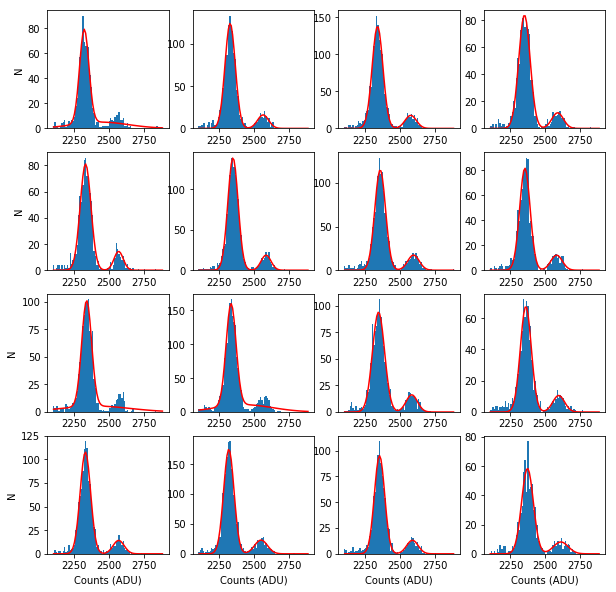

In [15]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    x = xs[i]
    y = ys[i]
    fit = fits[i]
    indx = i%4
    indy = i//4
    axs[indx][indy].bar(x, y, width=10)
    axs[indx][indy].plot(x, double_gaussian(x, fit[0]), c='r')
    if indx == 3:
        axs[indx][indy].set_xlabel('Counts (ADU)')
    if indy == 0:
        axs[indx][indy].set_ylabel('N')

In [16]:
afw_display.mtv(work_img) # have a look at an example amp

In [18]:
FE55_electrons = 1594

### Calculate gain and print them

In [19]:
for i in range(16):
    print("Gain for amp %s -- %.5f"%(detector[i].getName(), FE55_electrons/fits[i][0][1]))

Gain for amp C10 -- 0.68561
Gain for amp C11 -- 0.68284
Gain for amp C12 -- 0.68053
Gain for amp C13 -- 0.68318
Gain for amp C14 -- 0.68491
Gain for amp C15 -- 0.67897
Gain for amp C16 -- 0.68294
Gain for amp C17 -- 0.68767
Gain for amp C07 -- 0.68107
Gain for amp C06 -- 0.67561
Gain for amp C05 -- 0.67900
Gain for amp C04 -- 0.67693
Gain for amp C03 -- 0.67826
Gain for amp C02 -- 0.67734
Gain for amp C01 -- 0.67541
Gain for amp C00 -- 0.67207


### Calculate the noise in each image amp

In [ ]:
xs = []
ys = []
fits = []
detector = result.exposure.getDetector()
for amp in detector:
    print (amp)
    masked_img = result.exposure.getMaskedImage()
    work_img = masked_img[amp.getBBox()]
    arr = work_img.getImage().getArray()
    
    bkgd = numpy.median(arr) # estimate a background and subtract it
    print ("median {}".format(bkgd))
    arr -= bkgd

    thresh = afwDetection.Threshold(100)
    fs = afwDetection.FootprintSet(work_img, thresh) # detect hits
    fs = afwDetection.FootprintSet(fs, 1, False) # grow the detection footprints
    fs.makeHeavy(work_img) # what does this do. List of pixels plus values

    foots = fs.getFootprints()

    counts = []
    for foot in foots:
        if foot.getImageArray().size < 25:  # throw out big footprints/CRs since we know the hits should be in a single pixel modulo the charge diffusion.
            counts.append(numpy.sum(foot.getImageArray()))

    hist = numpy.histogram(counts, bins=2100.+numpy.array(range(80))*10.) # generate distribution to fit

    y = hist[0]
    x = [(hist[1][i]+hist[1][i+1])/2 for i in range(len(hist[1])-1)]

    fit = leastsq(double_gaussian_fit, [50.,2270.,50.,10.,2550.,40.], args=(x, y)) # starting parameters were determined by examining a representative distribution
    xs.append(x)
    ys.append(y)
    fits.append(fit)